# Libraries

In [1]:
import os
import sys

import random
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

from IPython.display import display
from keras import backend as K
from keras.models import model_from_yaml
from keras.utils.np_utils import to_categorical   
from keras.regularizers import l2
from keras.optimizers import Adam
# Libraries

from io import StringIO, BytesIO
import requests

from keras import backend as K

import random
import numpy as np
from datetime import datetime
from pytz import timezone

from PIL import Image

In [2]:
# CNN Libraries
import numpy as np

from keras import backend as K
from keras.models import Sequential
from keras.layers import ZeroPadding2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Flatten, Dense
from keras.regularizers import l2

In [3]:
# Siamese Libraries
from keras.models import Model
from keras.layers import Input, Lambda, Concatenate, Dot, Embedding, Flatten
import tensorflow as tf

In [4]:
# CAE Libraries
import math
from keras.layers import Dense, Conv2D, Flatten, Conv2DTranspose, BatchNormalization, MaxPooling2D, Reshape
import keras
from keras.preprocessing.image import img_to_array, array_to_img

# Connect to Drive

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
%cd gdrive/My Drive/visually aware/visually-aware-recommender-system/notebooks

/content/gdrive/My Drive/visually aware/visually-aware-recommender-system/notebooks


# Load Data

In [8]:
# !wget http://cseweb.ucsd.edu/~wckang/DVBPR/AmazonFashion6ImgPartitioned.npy
# !wget http://cseweb.ucsd.edu/~wckang/DVBPR/TradesyImgPartitioned.npy
!wget http://cseweb.ucsd.edu/~wckang/DVBPR/AmazonMenWithImgPartitioned.npy

--2021-07-17 13:33:25--  http://cseweb.ucsd.edu/~wckang/DVBPR/AmazonMenWithImgPartitioned.npy
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2276159058 (2.1G)
Saving to: ‘AmazonMenWithImgPartitioned.npy.2’

AmazonMenWithImgPar 100%[===================>]   2.12G  37.7MB/s    in 60s     

2021-07-17 13:34:25 (36.3 MB/s) - ‘AmazonMenWithImgPartitioned.npy.2’ saved [2276159058/2276159058]



In [9]:

# Load data - AmazonFashion6ImgPartitioned
# dataset = np.load("AmazonFashion6ImgPartitioned.npy",
#                   encoding="bytes", allow_pickle=True)

# # Load data - TradesyImgPartitioned
# dataset = np.load("TradesyImgPartitioned.npy",
#                   encoding="bytes", allow_pickle=True)
# [user_train, user_validation, user_test, items, user_num, item_num] = dataset

# Load data - AmazonMenWithImgPartitioned
dataset = np.load("AmazonMenWithImgPartitioned.npy",
                  encoding="bytes", allow_pickle=True)
[user_train, user_validation, user_test, items, user_num, item_num] = dataset

# Hyper parameters

In [10]:
# Network params
# image size
image_width = 224
image_height = 224

# latent dimensionality K
latent_dimensionality = 50

# weight decay - conv layer
lambda_cnn = 0.001
# weight decay - fc layer
lambda_fc = 0.001
# regularizer for theta_u
lambda_u = 1.0

In [11]:
# Training params
# epoch params
learning_rate = 1e-4
training_epoch = 3 # 30
batch_count = 2**8
# batch_size = 2**7
validation_sample_count = 100

#Convolutional Autoencoder Model

##Load Autoencoder

In [12]:
ae_path = "gdrive/My Drive/visually aware/autoencoder model/autoencoder_amazon_men"
autoencoder = keras.models.load_model(ae_path)

encoder_path = "gdrive/My Drive/visually aware/autoencoder model/encoder_amazon_men"
encoder = keras.models.load_model(encoder_path)

decoder_path = "gdrive/My Drive/visually aware/autoencoder model/decoder_amazon_men"
decoder = keras.models.load_model(decoder_path)

In [13]:
trained_encoder = encoder

In [14]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
encoder (Functional)         (None, 147)               305107    
_________________________________________________________________
decoder (Functional)         (None, 224, 224, 3)       72259     
Total params: 377,366
Trainable params: 376,982
Non-trainable params: 384
_________________________________________________________________


In [15]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 32)        0   

In [16]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 147)]             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 3)           0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 64)        1792      
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 64)        256       
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 56, 56, 32)        1846

##Train Autoencoder

###Build Autoencoder

In [17]:
def get_autoencoder_model(input_shape = (224,224,3), encoding_shape=49):
  
  # the input image
  input_img = Input(input_shape)

  # encoder
  encoded = Conv2D(16, (3,3), activation='relu', input_shape=input_shape)(input_img)
  encoded = MaxPooling2D((2, 2))(encoded)
  encoded = Conv2D(32, (3,3), activation='relu')(encoded)
  encoded = MaxPooling2D((2, 2))(encoded)
  encoded = Conv2D(32, (3,3), activation='relu')(encoded)
  encoded = MaxPooling2D((2, 2))(encoded)
  encoded = Conv2D(64, (3,3), activation='relu')(encoded)
  encoded = MaxPooling2D((2, 2))(encoded)
  encoded = Conv2D(64, (3,3), activation='relu')(encoded)
  encoded = MaxPooling2D((2, 2))(encoded)
  l = Flatten()(encoded)
  l = Dense(encoding_shape * 3, activation="softmax")(l)

  encoder = Model(input_img, l, name="encoder")

  # decoder
  latent_inputs = Input(shape=(encoding_shape * 3,))
  decoded = Reshape((int(math.sqrt(encoding_shape)), int(math.sqrt(encoding_shape)),3))(latent_inputs)
  decoded = Conv2DTranspose(64, (3,3), strides = 2, activation='relu', padding='same')(decoded)
  decoded = BatchNormalization()(decoded)
  decoded = Conv2DTranspose(64, (3,3), strides = 2, activation='relu', padding='same')(decoded)
  decoded = BatchNormalization()(decoded)
  decoded = Conv2DTranspose(32, (3,3), strides = 2, activation="relu", padding="same")(decoded)
  decoded = BatchNormalization()(decoded)
  decoded = Conv2DTranspose(32, (3,3), strides = 2, activation="relu", padding="same")(decoded)
  decoded = BatchNormalization()(decoded)
  decoded = Conv2DTranspose(16, (3,3), strides = 2, activation="relu", padding="same")(decoded)
  decoded = Conv2D(3, (3,3), activation='sigmoid', padding="same")(decoded)

  decoder = Model(latent_inputs, decoded, name="decoder")
  

  # create the complete autoencoder model
  autoencoder_model = Model(input_img, decoder(encoder(input_img)), name="autoencoder")
  autoencoder_model.summary()

  autoencoder_model.compile(optimizer='adam', loss='mse')

  return autoencoder_model, encoder, decoder




###Training

In [14]:
cae_batch_size = 32

In [15]:
def cae_generator(items=items, batch_size=cae_batch_size, image_height=224, image_width=224):

  while True:
    ind = 0
    imgs_list = []
    num_items = 0

    for item_ind in range(batch_size):# range(len(items)):
      # print(item_ind)
      item = items[ind]
      # print(num_items)
      try:
        # image_url = items[item][b'imUrl'].decode("utf-8")
        image_url = item[b'imUrl'].decode("utf-8")
        response = requests.get(image_url)
        img = Image.open(BytesIO(response.content))

        img_arr = np.uint8(np.asarray(img.convert("RGB").resize((image_height, image_width))))
        img_arr = (img_arr - 127.5) / 127.5
        imgs_list.append(img_arr)

        num_items+=1
      except Exception as e:
        # print(e)
        continue
      
      ind+=1 #go to next item image
    # print(imgs_list)
    # print(np.asarray(imgs_list).shape)
    yield [np.asarray(imgs_list)], np.asarray(imgs_list)
    num_items = 0
    imgs_list = []
    #print(f"finished loading {num_items} items images")
    

In [16]:
# create the autoencoder model
autoencoder, encoder, decoder = get_autoencoder_model()
trained_encoder = encoder

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
encoder (Functional)         (None, 147)               305107    
_________________________________________________________________
decoder (Functional)         (None, 224, 224, 3)       72259     
Total params: 377,366
Trainable params: 376,982
Non-trainable params: 384
_________________________________________________________________


In [17]:
encoder.summary()
decoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 32)        0   

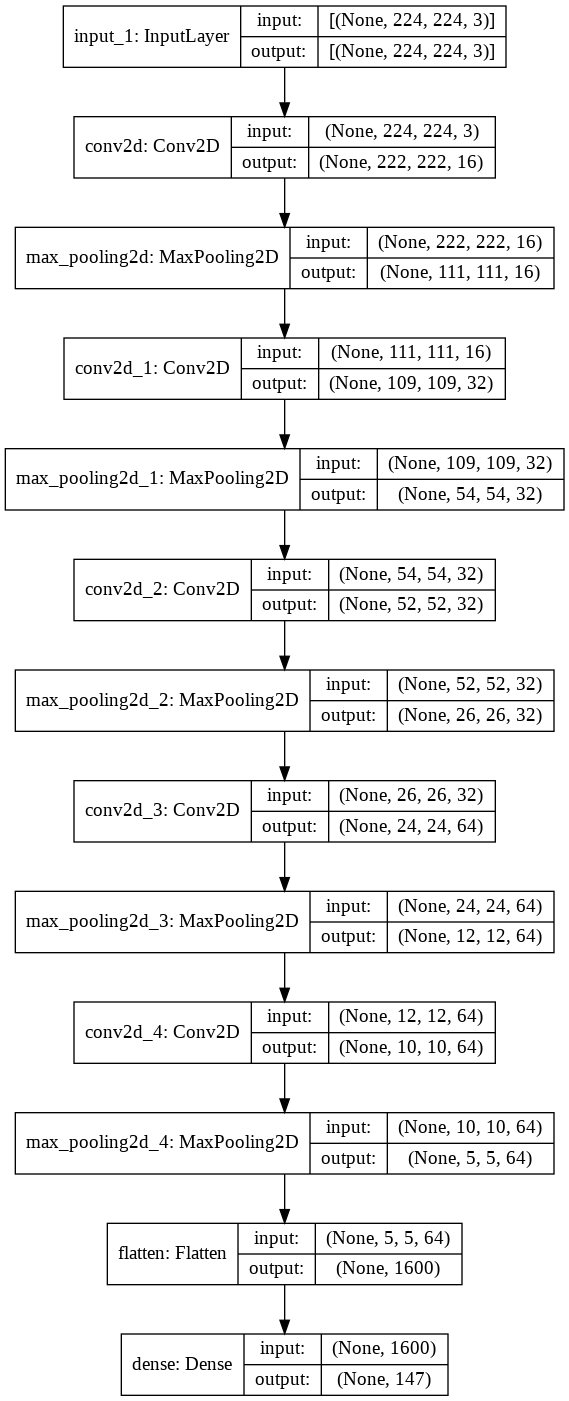

In [18]:
from keras.utils.vis_utils import plot_model

plot_model(encoder, show_shapes=True)

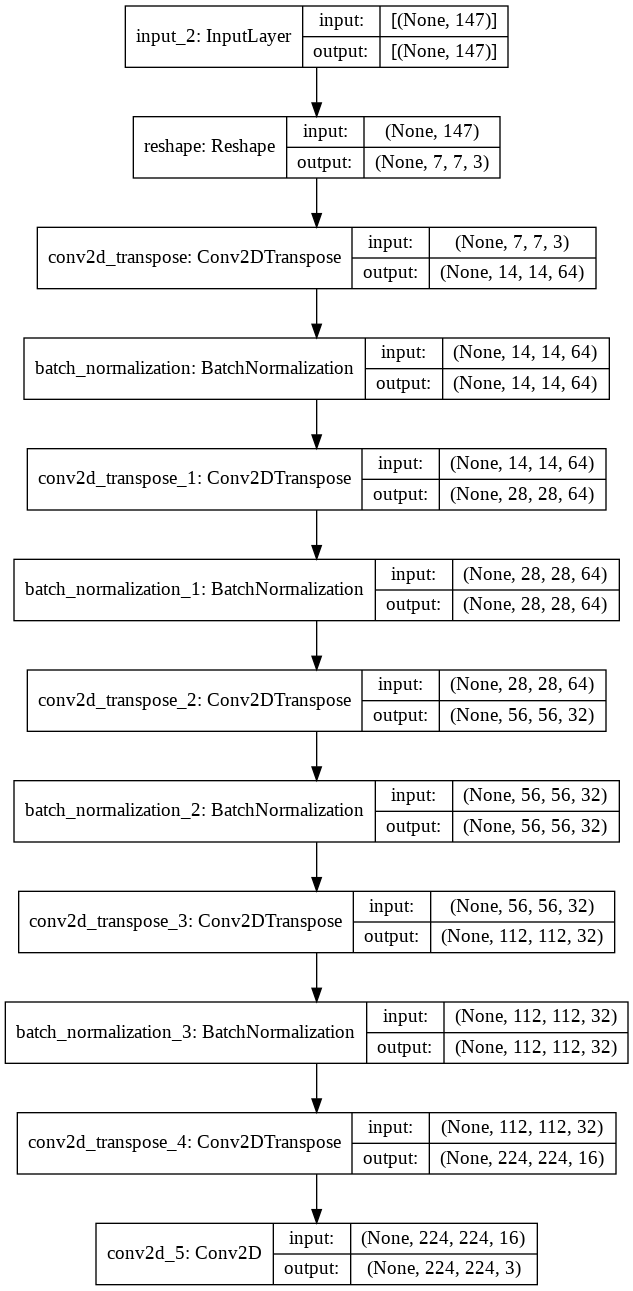

In [19]:
plot_model(decoder, show_shapes=True)

In [ ]:
generator = cae_generator()
autoencoder.fit(x=generator, steps_per_epoch=int(len(items)/cae_batch_size), epochs = 3)

Epoch 1/3
3457/3457 [==============================] - 1408s 393ms/step - loss: 0.1450
Epoch 2/3
3457/3457 [==============================] - 1353s 391ms/step - loss: 0.1131
Epoch 3/3
1858/3457 [===============>..............] - ETA: 10:26 - loss: 0.1113

####Save Autoencoder

In [ ]:
ae_save_path = "gdrive/My Drive/visually aware/autoencoder model/autoencoder_amazon_men"
autoencoder.save(ae_save_path)

encoder_save_path = "gdrive/My Drive/visually aware/autoencoder model/encoder_amazon_men"
encoder.save(encoder_save_path)

decoder_save_path = "gdrive/My Drive/visually aware/autoencoder model/decoder_amazon_men"
decoder.save(decoder_save_path)

##Test Autoencoder

In [18]:
image_url = items[2000][b'imUrl'].decode("utf-8")
response = requests.get(image_url)
img = Image.open(BytesIO(response.content))
img_arr = np.uint8(np.asarray(img.convert("RGB").resize((224, 224))))
img_arr = (img_arr - 127.5) / 127.5

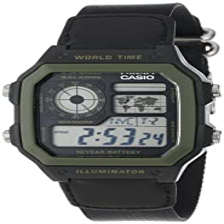

In [19]:
array_to_img(img_arr)

In [20]:
embedding = encoder.predict(np.asarray([img_arr]))

In [21]:
reconstructed_img = decoder.predict(embedding)

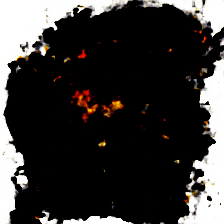

In [22]:
array_to_img(reconstructed_img[0])

##Siamese Leg Encoder Model

In [23]:
def get_trainable_encoder(encoder, latent_dim):
  # freeze all encoder layers
  for layer in encoder.layers[:]:
    layer.trainable = False

  # # check all layers are frozen
  # for layer in encoder.layers:
  #   print(layer, layer.trainable)

  trainable_encoder = Sequential()
  # add the non trainable encoder
  trainable_encoder.add(encoder)
  # add a new trainable layer
  trainable_encoder.add(Dense(latent_dim))

  return trainable_encoder

# Subsets

In [24]:
user_num_original = user_num
user_train_original = user_train
user_val_original = user_validation

In [25]:
# for each batch, force the number of users to be the same
batch_size = 128
num_batches = int(user_num_original / batch_size)

# one complete model will be linked to each user_subset
user_subsets = dict(zip(range(num_batches), np.array_split(range(user_num_original), num_batches)))

In [26]:
# for each batch, force the number of users to be the same
batch_count = 2**8
user_num_new = (user_num_original - (user_num_original % batch_count))

# one complete model will be linked to each user_subset
user_subsets = dict(zip(range(batch_count), np.array_split(range(user_num_new), batch_count)))

# Utils

In [27]:
def image_translate(image_bytes,
                    image_width=224,
                    image_height=224):
    img = (np.uint8(np.asarray(Image.open(BytesIO(image_bytes)).convert("RGB").resize((image_height, image_width)))) - 127.5)  / 127.5
    return img

In [28]:
def uniform_train_sample_batch(user_train_ratings, item_images, image_width=224, 
                               image_height=224, sample=True, batch_size=None, user_idx=None):
    """
    validation_sample_count (int): Number of not-observed items to sample to get the validation set for each user.
    """

    if batch_size is not None:
        users = range(batch_size)
    else:
        users = user_idx

    triplet_train_batch = {}

    for b in users:

        # training set
        if sample:
            u = random.randrange(len(user_train_ratings))
        else:
            u = b

        i = user_train_ratings[u][random.randrange(len(user_train_ratings[u]))][b'productid']
        j = random.randrange(len(item_images))
        while j in [item[b'productid'] for item in user_train_ratings[u]]:
            j = random.randrange(len(item_images))

        image_i = image_translate(item_images[i][b'imgs'], 
                                  image_width, 
                                  image_height)
        image_j = image_translate(item_images[j][b'imgs'],
                                  image_width, 
                                  image_height)
        triplet_train_batch[u] = [image_i,
                                  image_j]
        
    return triplet_train_batch

In [29]:
def uniform_validation_sample_batch(user_validation_ratings,
                                          item_images,
                                          image_width=224,
                                          image_height=224,
                                          validation_sample_count=1000,
                                          sample=True,
                                          batch_size=None,
                                          user_idx=None):
    """
    validation_sample_count (int): Number of not-observed items to sample to get the validation set for each user.
    """

    if batch_size is not None:
        users = range(batch_size)
    else:
        users = user_idx

    triplet_validation_batch = {}
    for b in users:

        if sample:
            u = random.randrange(len(user_validation_ratings))
        else:
            u = b

        # validation set
        i = user_validation_ratings[u][0][b'productid']
        image_i = image_translate(item_images[i][b'imgs'],
                                  image_width, 
                                  image_height)

        reviewed_items = set()
        for item in user_validation_ratings[u]:
            reviewed_items.add(item[b'productid'])
        reviewed_items.add(user_validation_ratings[u][0][b'productid'])

        triplet_validation_batch[u] = []
        for j in random.sample(range(len(item_images)), validation_sample_count):
            if j not in reviewed_items:
                image_j = image_translate(item_images[j][b'imgs'],
                                          image_width, 
                                          image_height)
                triplet_validation_batch[u].append([image_i,
                                                    image_j])

    return triplet_validation_batch

In [30]:
# Define the loss function as ln(sigmoid) according to the BPR method
# Pay attention.
# BPR wants to maximize the loss function while Keras engine minimizes it
def bpr_loss(label_matrix, prediction_matrix):
    return 1 - tf.reduce_sum(tf.math.log(tf.sigmoid(prediction_matrix)))
    # return -1.0 * tf.reduce_sum(tf.math.log(tf.sigmoid(prediction_matrix)))

In [31]:
# Define the metric as AUC according to the BPR method
#
# Count the ratio of prediction value > 0
# i.e., predicting positive item score > negative item score for a user
#
# Pay attention.
# Do not use a plain integer as a parameter to switch,
# instead, pass a compatible tensor (for example create it with K.zeros_like)
def auc(label_tensor, prediction_tensor):
    return K.mean(K.switch(prediction_tensor > K.zeros_like(prediction_tensor),
                           K.ones_like(prediction_tensor),    # 1
                           K.zeros_like(prediction_tensor)))  # 0

In [32]:
optimizer = tf.keras.optimizers.Adam()

#Siamese Network with Autoencoder

In [33]:
def AutoencoderSiameseNet(trained_encoder, users_dim, width, height, depth,latent_dim, w_init="RandomNormal", cnn_w_regularizer=None, fc_w_regularizer=None, u_w_regularizer=None, b_init="RandomNormal"):

        # Define the input
        #   Unlike the Sequential model, you must create and define
        #   a standalone "Input" layer that specifies the shape of input
        #   data. The input layer takes a "shape" argument, which is a
        #   tuple that indicates the dimensionality of the input data.
        user_input = Input((1,), name='User')

        image_shape = (width, height, depth)

        left_input = Input(image_shape,
                           name="observed_image")
        
        right_input = Input(image_shape,
                            name="non_observed_image")

        # # Build convnet to use in each siamese 'leg'
        # conv_net = CNN(width,height,depth,latent_dim, w_init, cnn_w_regularizer, fc_w_regularizer, b_init)

        # Build encoder based model to use in each siamese leg
        trained_encoder_net = get_trainable_encoder(trained_encoder, latent_dim)

        # merge the two encoded inputs through the L1 distance
        L1_distance = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]),
                             name="score_difference")


        # preference layer
        preference_relationship = Dot(axes=1,
                                      name="score_rank")

        # Apply the pipeline to the inputs
        #
        # call the convnet Sequential model on each of the input tensors
        # so params will be shared
        encoded_l = trained_encoder_net(left_input)
        encoded_r = trained_encoder_net(right_input)

        # merge the two encoded inputs through the L1 distance
        L1_dist = tf.keras.layers.Subtract()([encoded_l, encoded_r])
        
        # retrieve the single user preference
        user_vec = Flatten(name='FlattenUsers')(Embedding(user_num+1, latent_dimensionality, name = 'User-Embedding', embeddings_initializer= tf.keras.initializers.RandomUniform(0,0.01),
                                                          input_length=1, embeddings_regularizer=u_w_regularizer)(user_input))
        
        # get the preference score
        prediction = preference_relationship([user_vec, L1_dist])
        
        # Create the model
        model = Model(inputs=[user_input, left_input, right_input],
                      outputs=prediction)
        
        model.summary()
        
        
        return model

# Build Model

##Autoencoder Based Model

In [63]:
cae_siamese_net = AutoencoderSiameseNet(trained_encoder = trained_encoder,
                                        users_dim=len(user_subsets[0]),
                                        width=image_width,
                                        height=image_height,
                                        depth=3,
                                        latent_dim=latent_dimensionality,
                                        cnn_w_regularizer=l2(lambda_cnn),
                                        fc_w_regularizer=l2(lambda_fc),
                                        u_w_regularizer=l2(lambda_u),
                                        w_init = tf.keras.initializers.GlorotNormal())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
User (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
observed_image (InputLayer)     [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
non_observed_image (InputLayer) [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
User-Embedding (Embedding)      (None, 1, 50)        1712250     User[0][0]                       
____________________________________________________________________________________________

In [64]:
from tensorflow.keras import regularizers

optimizer = Adam()
cae_siamese_net.compile(loss=bpr_loss,
                         optimizer=optimizer,
                         metrics=[auc])

# Train

##Helper Functions

In [65]:
patience = 10
best_loss = 1e6
rounds_without_improvement = 0

opt_auc = {}
for sub in user_subsets.keys():
    opt_auc[sub] = 0.0

In [66]:
def get_train(user_subset, user_train):
  train = uniform_train_sample_batch(
      sample=False,
      user_idx=user_subset,
      user_train_ratings=user_train,
      item_images=items,
      image_width=image_width,
      image_height=image_height)
  return train

In [67]:
def get_validation(user_subset, user_validation):
  validation = uniform_validation_sample_batch(
      sample=False,
      user_idx=user_subset,
      user_validation_ratings=user_validation,
      item_images=items,
      image_width=image_width,
      image_height=image_height,
      validation_sample_count=validation_sample_count)
  return validation

In [68]:
def training(user_placeholder, observed_image, not_observed_image, labels):
  # compute the loss on the training set
  loss = conv_siamese_net.train_on_batch(
      [np.array(user_placeholder),
      np.array(observed_image),
      np.array(not_observed_image)],
      labels)
  return loss

In [69]:
# compute the loss on the training set

def train_step(user_placeholder, observed_image, not_observed_image, labels):

  with tf.GradientTape() as tape:
    logits = conv_siamese_net([np.array(user_placeholder), np.array(observed_image), np.array(not_observed_image)], training=True)
    loss_value = bpr_loss(labels, logits)
    print(f"bpr: {loss_value}")
    auc_score = auc(labels, logits)

  grads = tape.gradient(loss_value, conv_siamese_net.trainable_weights)
  optimizer.apply_gradients(zip(grads, conv_siamese_net.trainable_weights))
  
  return loss_value, auc_score

In [70]:
def get_train_triplet_lists(train):
    user_placeholder = []
    observed_image = []
    not_observed_image = []
    
    for u, triplet in train.items():
        user_placeholder.append(u)
        observed_image.append(triplet[0])
        not_observed_image.append(triplet[1])
        
    # label set does not exist in BPR, so we give Keras with a dummy label set
    labels = np.ones((len(train), 1), dtype=int)
    
    return user_placeholder, observed_image, not_observed_image, labels

In [71]:
def get_val_triplet_lists(validation):
    auc_user = []
    for u, triplet_list in validation.items():
        user_placeholder = []
        observed_image = []
        not_observed_image = []
        
        for triplet in triplet_list:
            user_placeholder.append(u)
            observed_image.append(triplet[0])
            not_observed_image.append(triplet[1])
        
        score = conv_siamese_net.predict(
            [np.array(user_placeholder),
            np.array(observed_image),
            np.array(not_observed_image)])
        
        auc_user.append(np.where(score > 0, 1, 0).reshape(1, len(triplet_list)).mean())
  
    return auc_user

In [74]:
def train_generator():
  batches = range(batch_count)
  visited_batches = []
  num_batches_in_curr_epoch = 0
  user_subset_idx = 0
  while True:
    visited_batches.append(user_subset_idx) # append to visited
    user_subset = user_subsets[user_subset_idx] # get batch users
    user_train = {k: v for k, v in user_train_original.items() if k in user_subset}
    train = get_train(user_subset, user_train)
    user_placeholder, observed_image, not_observed_image, labels = get_train_triplet_lists(train)

    yield [np.asarray(user_placeholder), np.asarray(observed_image), np.asarray(not_observed_image)], np.asarray(labels)
    num_batches_in_curr_epoch+=1
    user_subset_idx+=1
    if num_batches_in_curr_epoch >= batch_count:
      # reset the lists
      visited_batches = []
      num_batches_in_curr_epoch = 0
      user_subset_idx = 0
    

In [75]:
def val_generator():
  batches = range(batch_count)
  num_batches_in_curr_epoch = 0
  user_subset_idx = 0
  while True:
    user_subset = user_subsets[user_subset_idx] # get batch users
    validation = get_validation(user_subset, user_validation)
    user_placeholder, observed_image, not_observed_image, labels = get_val_triplet_lists(validation)
    
    yield [np.asarray(user_placeholder), np.asarray(observed_image), np.asarray(not_observed_image)], np.asarray(labels)

    num_batches_in_curr_epoch+=1
    user_subset_idx+=1
    
    if num_batches_in_curr_epoch >= batch_count:
      # reset the lists
      num_batches_in_curr_epoch = 0
      user_subset_idx = 0

##CAE Training

In [76]:
train_generator = train_generator()
validation_generator = val_generator()

In [ ]:
val_scores = []
history = []
model_path = "cae_siamese_net_trained_model_30_epochs_amazon_men"

for i in range(3):
  history.append(cae_siamese_net.fit(x=train_generator, steps_per_epoch = batch_count, epochs = 10))
  val_scores.append(cae_siamese_net.evaluate(validation_generator, steps = batch_count))
  print(val_scores)
  cae_siamese_net.save(model_path, save_traces=True, include_optimizer=True)

Epoch 1/10
256/256 [==============================] - 403s 2s/step - loss: 97.3451 - auc: 0.4959
Epoch 2/10
256/256 [==============================] - 394s 2s/step - loss: 93.2002 - auc: 0.5010
Epoch 3/10
256/256 [==============================] - 390s 2s/step - loss: 93.2035 - auc: 0.5027
Epoch 4/10
256/256 [==============================] - 368s 1s/step - loss: 93.2058 - auc: 0.5048
Epoch 5/10
256/256 [==============================] - 367s 1s/step - loss: 93.2078 - auc: 0.4986
Epoch 6/10
256/256 [==============================] - 368s 1s/step - loss: 93.2094 - auc: 0.4975
Epoch 7/10
256/256 [==============================] - 367s 1s/step - loss: 93.2110 - auc: 0.4961
Epoch 8/10
256/256 [==============================] - 370s 1s/step - loss: 93.2123 - auc: 0.4939
Epoch 9/10
256/256 [==============================] - 369s 1s/step - loss: 93.2137 - auc: 0.4977
Epoch 10/10
256/256 [==============================] - 371s 1s/step - loss: 93.2145 - auc: 0.4949


# Test

In [ ]:
def test_generator():
  batches = range(batch_count)
  num_batches_in_curr_epoch = 0
  user_subset_idx = 0
  while True:
    user_subset = user_subsets[user_subset_idx] # get batch users
    test = get_validation(user_subset, user_test)
    user_placeholder, observed_image, not_observed_image, labels = get_val_triplet_lists(test)
    
    yield [np.asarray(user_placeholder), np.asarray(observed_image), np.asarray(not_observed_image)], np.asarray(labels)

    num_batches_in_curr_epoch+=1
    user_subset_idx+=1
    
    if num_batches_in_curr_epoch >= batch_count:
      # reset the lists
      num_batches_in_curr_epoch = 0
      user_subset_idx = 0

In [ ]:
test_generator = test_generator()
cae_siamese_net.evaluate(test_generator, steps = batch_count)